In [ ]:
import warnings
import pickle, os
import numpy as np 
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("hf://datasets/milind27/CO2_Vehicle_Emmisions/vehicledata.csv")
df.drop(
        inplace=True,
        columns=[
                "Description",
                ]
        )
df.isnull().sum()

Manufacturer                      0
Model                             0
Transmission                      9
Vehicle_Type                      0
Engine_Capacity                   0
Fuel_Type                         0
Powertrain                        0
Engine_PowerPS                    0
Engine_Power                      0
Emissions_CO2                     0
THC0Emissions0[mg/km]           745
Emissions NOx [mg/km]             0
THC + NOx Emissions [mg/km]    3331
Particulates [No.] [mg/km]     2959
RDE NOx Urban                  1956
RDE NOx Combined               1756
dtype: int64

In [ ]:
df = pd.read_csv("hf://datasets/milind27/CO2_Vehicle_Emmisions/vehicledata.csv")        
df = df[[
        "Transmission",
        "Vehicle_Type",
        "Engine_Capacity",
        "Fuel_Type",
        "Powertrain",
        "Engine_PowerPS",
        "Emissions_CO2"
        ]]

df.isnull().sum()

Transmission       9
Vehicle_Type       0
Engine_Capacity    0
Fuel_Type          0
Powertrain         0
Engine_PowerPS     0
Emissions_CO2      0
dtype: int64

In [ ]:
def co2_eda_pipeline():

        df = pd.read_csv("hf://datasets/milind27/CO2_Vehicle_Emmisions/vehicledata.csv")        
        df = df[[
                "Transmission",
                "Vehicle_Type",
                "Engine_Capacity",
                "Fuel_Type",
                "Powertrain",
                "Engine_PowerPS",
                ]]

        cat_cols = df.select_dtypes(include="object").columns
        num_cols = df.select_dtypes(exclude="object").columns

        print("n cat cols: ", len(cat_cols))
        print("n num cols: ", len(num_cols))

        # plot the distribution of the categorical columns
        plt.figure(figsize=(20, 20))
        for i, col in enumerate(cat_cols):
                df[col] = df[col].str.strip()
                plt.subplot(2, 2, i+1)
                sns.countplot(df[col])
                plt.title(col)

        plt.suptitle("Distribution of Categorical Columns")
        plt.tight_layout()
        plt.show()

        # plot the distribution of the numerical columns
        plt.figure(figsize=(20, 20))
        for i, col in enumerate(num_cols):
                plt.subplot(2, 1, i+1)
                sns.histplot(df[col])
                plt.title(col)

        plt.suptitle("Distribution of Numerical Columns")
        plt.tight_layout()
        plt.show()

n cat cols:  4
n num cols:  2


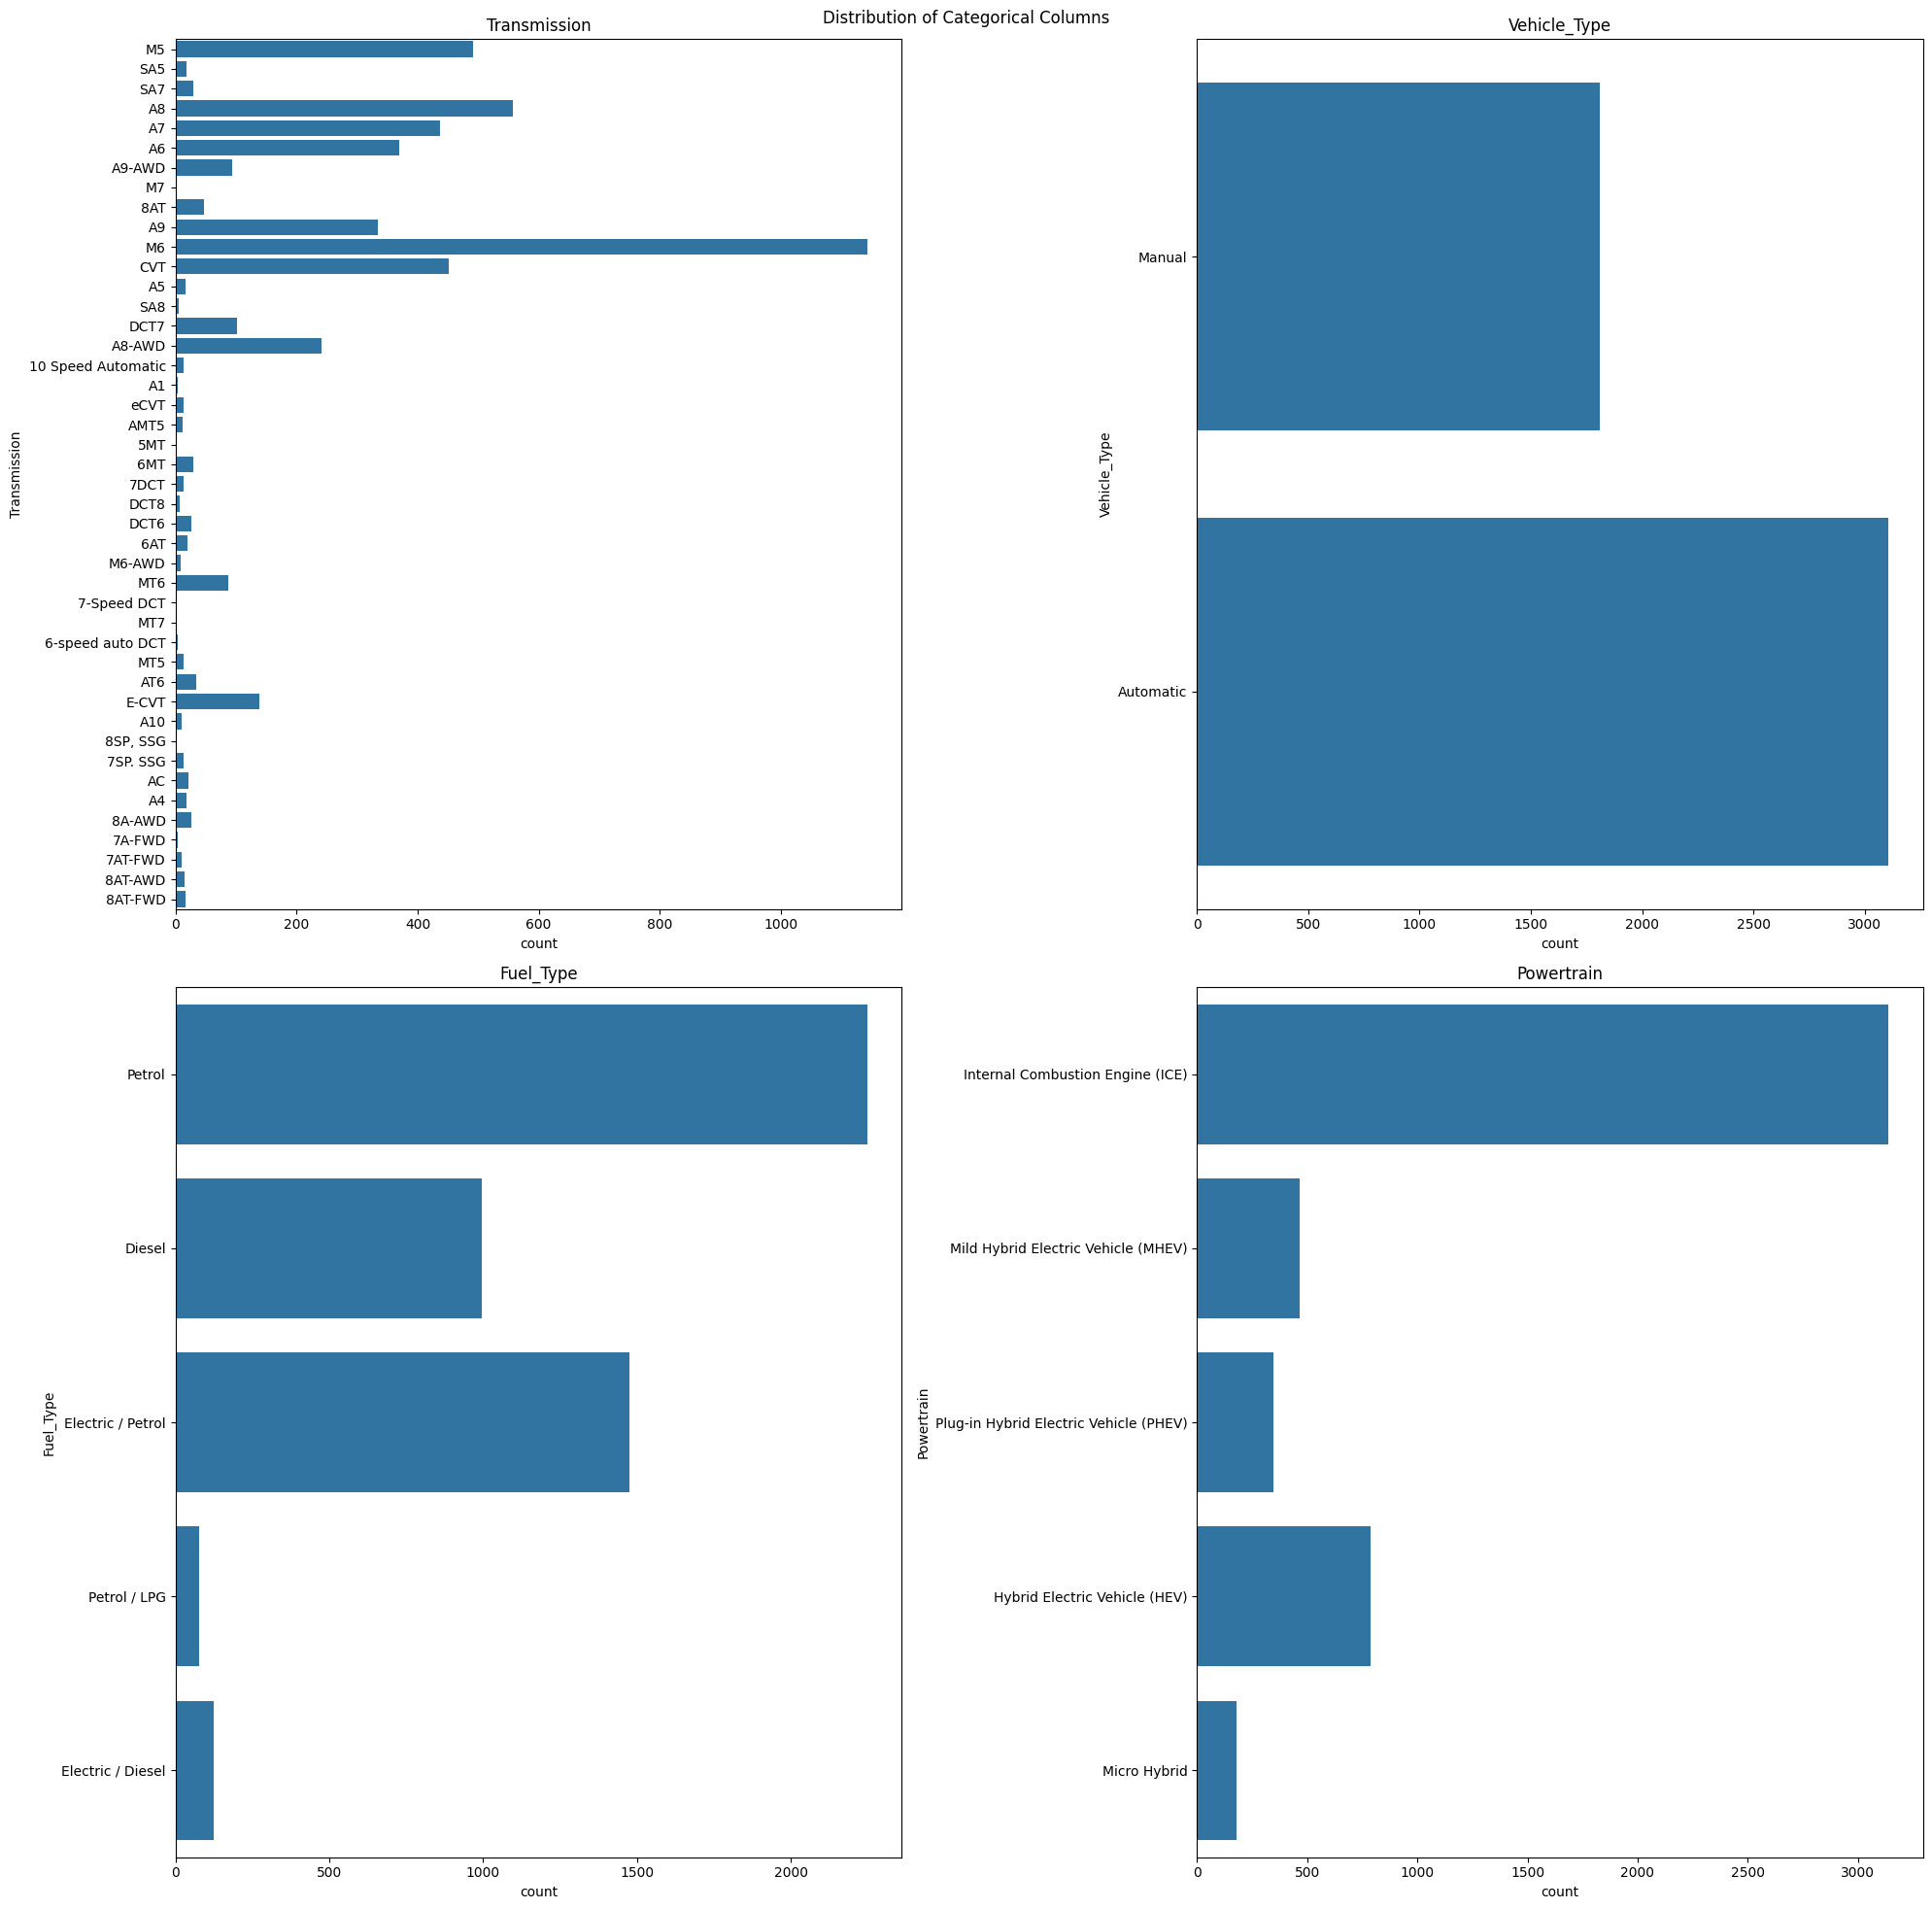

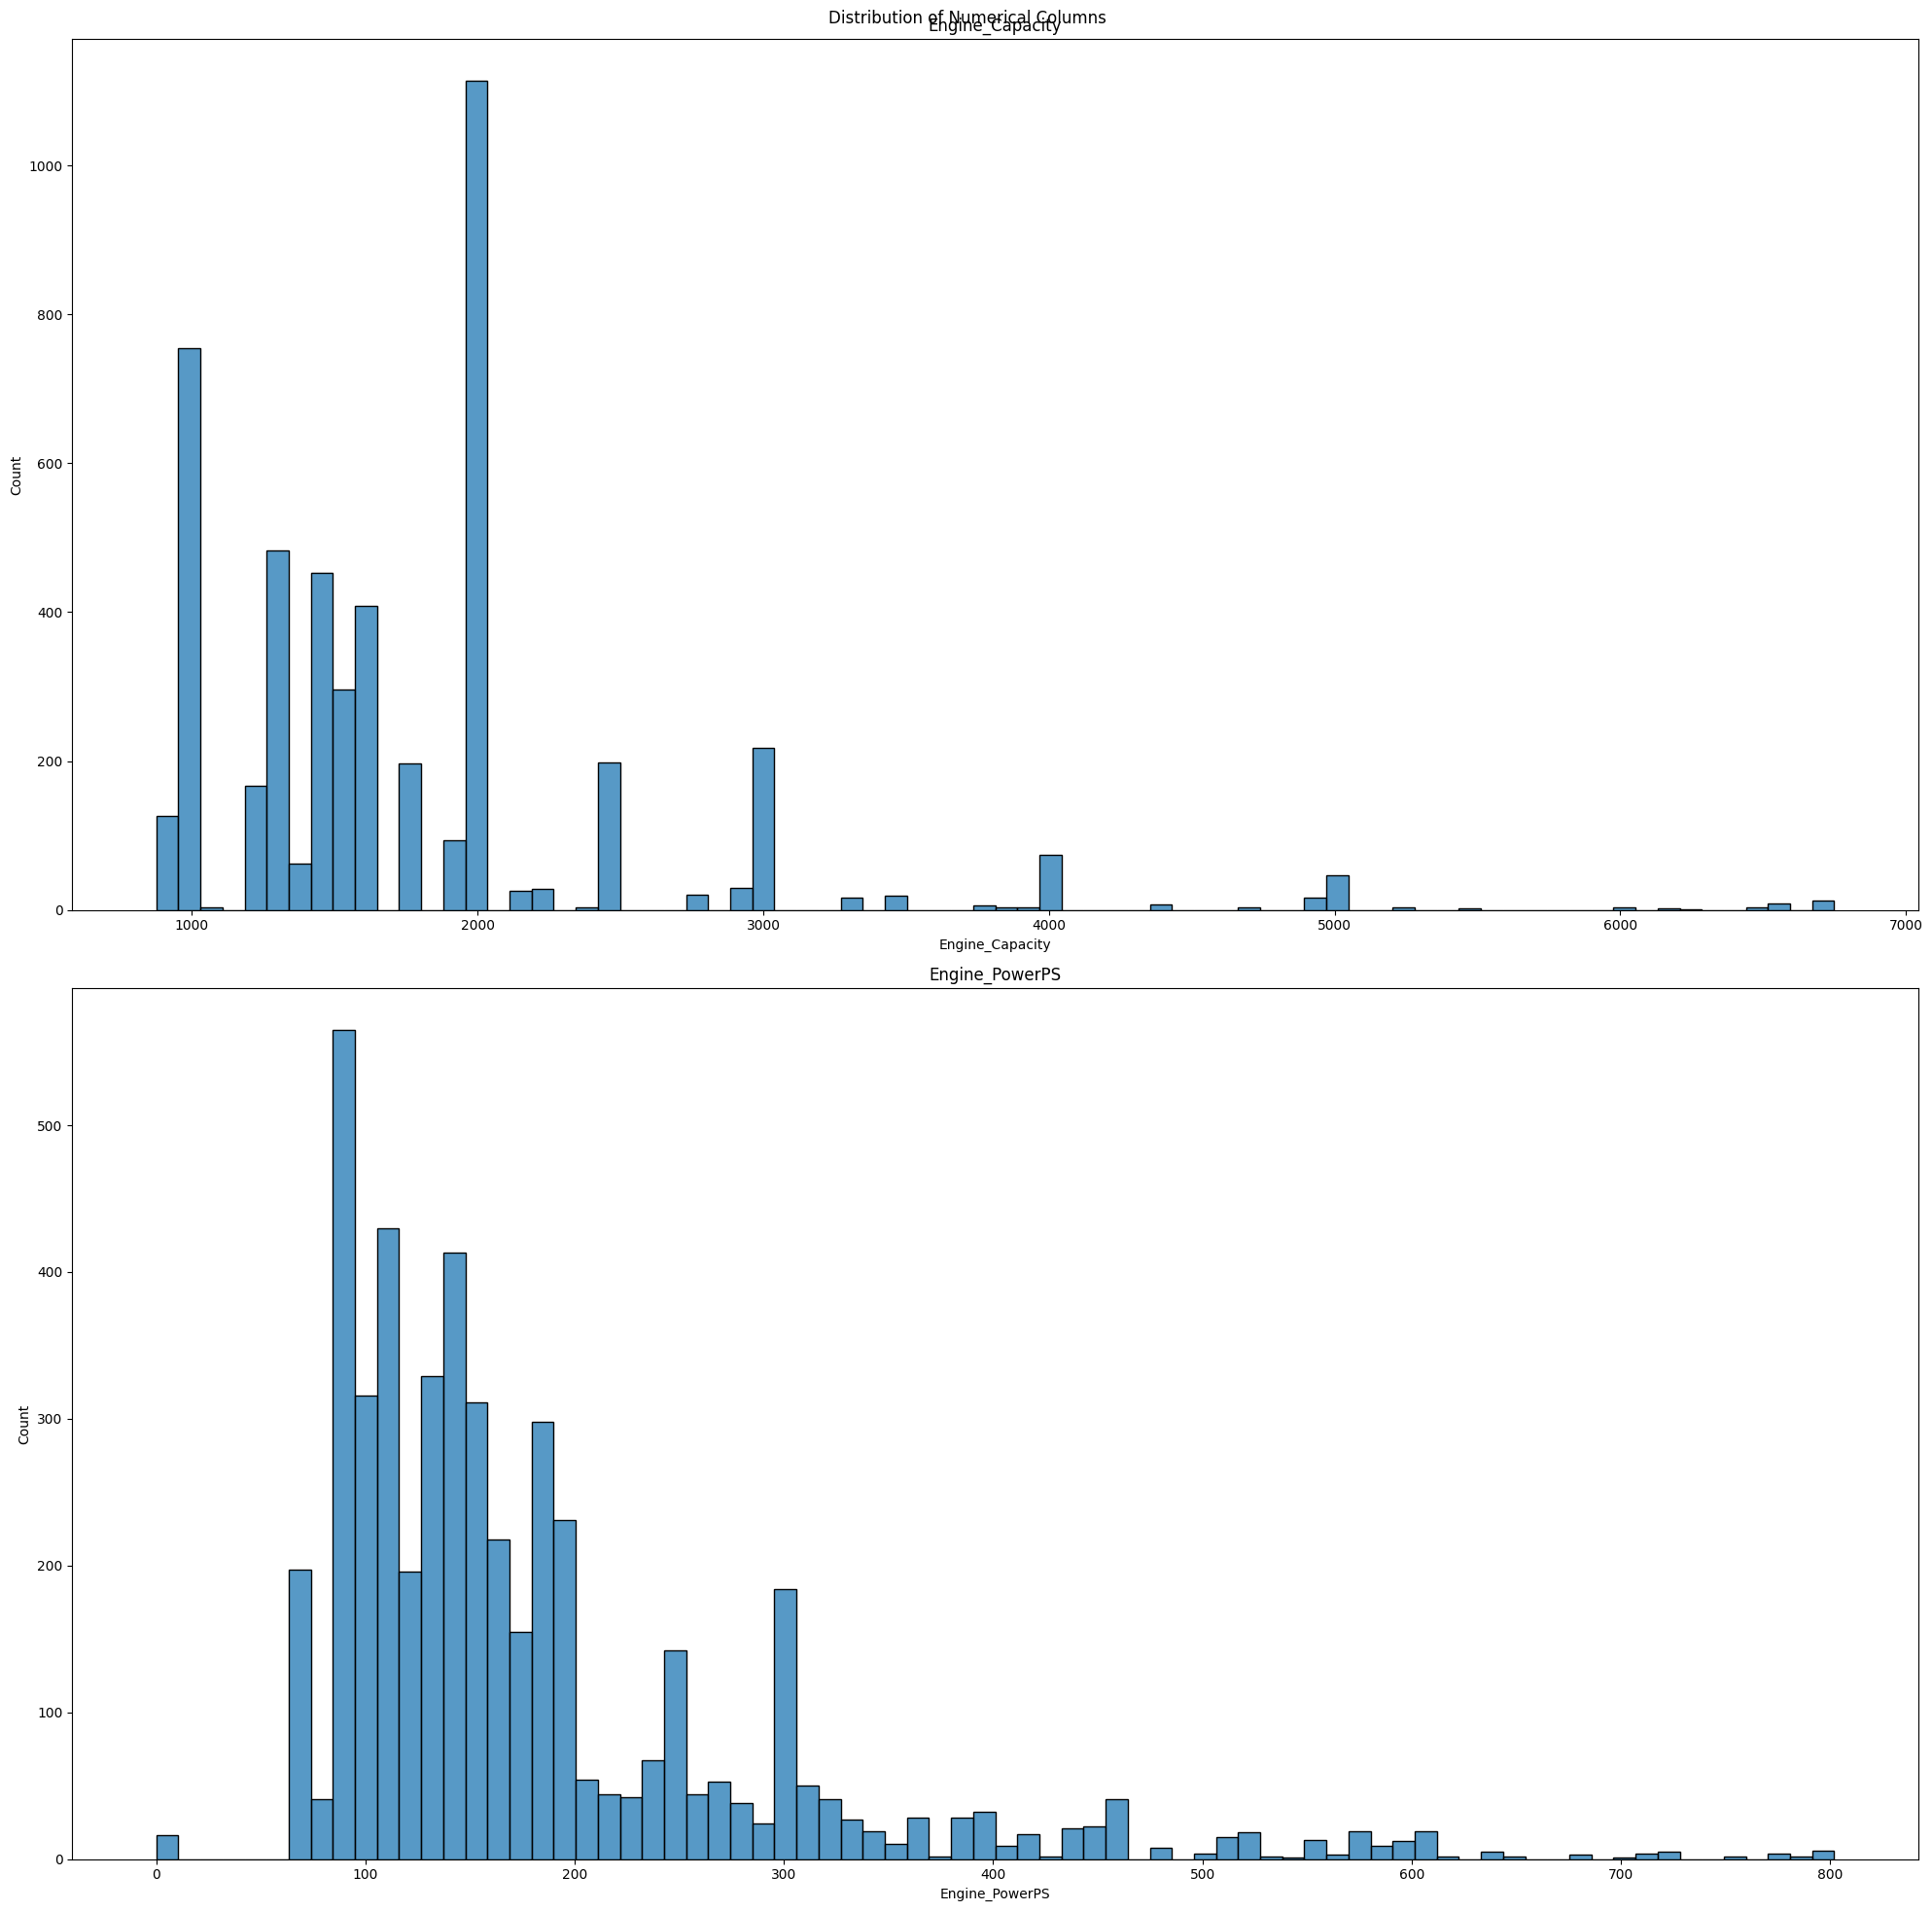

In [12]:
co2_eda_pipeline()

In [ ]:
def co2_data_pipeline(encoder_path = 'artifacts/encoder_co2_emmision.pkl'):
       
        df = pd.read_csv("hf://datasets/milind27/CO2_Vehicle_Emmisions/vehicledata.csv")        
        df = df[[
                "Transmission",
                "Vehicle_Type",
                "Engine_Capacity",
                "Fuel_Type",
                "Powertrain",
                "Engine_PowerPS",
                "Emissions_CO2"
                ]]
        
        Y = df["Emissions_CO2"].values
        del df["Emissions_CO2"]

        cat_cols = df.select_dtypes(include="object").columns
        num_cols = df.select_dtypes(exclude="object").columns

        print("n cat cols: ", len(cat_cols))
        print("n num cols: ", len(num_cols))

        encoder_dict = defaultdict(LabelEncoder)
        if not os.path.exists(encoder_path):
                for col in cat_cols:
                        df[col] = df[col].str.strip()
                        encoder_dict[col].fit(df[col])
                        
                with open(encoder_path, "wb") as f:
                        pickle.dump(dict(encoder_dict), f)

        with open(encoder_path, "rb") as f:
                encoder_dict = pickle.load(f)

        for col in cat_cols:
                df[col] = df[col].str.strip()
                df[col] = encoder_dict[col].transform(df[col])

        X = df.values

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                        X, Y, 
                                                        test_size=0.2, 
                                                        random_state=42
                                                        )
        
        return Xtrain, Xtest, Ytrain, Ytest

In [16]:
Xtrain, Xtest, Ytrain, Ytest = co2_data_pipeline()
print("\nXtrain Shape  : ", Xtrain.shape)
print("Xtest Shape   : ", Xtest.shape)
print("Ytrain Shape  : ", Ytrain.shape)
print("Ytest Shape   : ", Ytest.shape)

n cat cols:  4
n num cols:  2

Xtrain Shape  :  (3932, 6)
Xtest Shape   :  (984, 6)
Ytrain Shape  :  (3932,)
Ytest Shape   :  (984,)


In [17]:
cls_01 = RandomForestRegressor(
                            n_estimators = 200, 
                            max_depth = 15
                            )

cls_02 = XGBRegressor(
                    n_estimators = 200, 
                    max_depth = 15
                    )

cls = VotingRegressor(
                    estimators = [
                        ('cls_01', cls_01),
                        ('cls_02', cls_02)
                    ]
                    )

In [18]:
cls.fit(Xtrain, Ytrain)

VotingRegressor(estimators=[('cls_01',
                             RandomForestRegressor(max_depth=15,
                                                   n_estimators=200)),
                            ('cls_02',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=15,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=200,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [ ]:
with open("artifacts/model_co2_emmision.pkl", "wb") as f:
        pickle.dump(cls, f)

In [20]:
Ptrain = cls.predict(Xtrain)
Ptest = cls.predict(Xtest)

In [21]:
mse_train = mean_squared_error(Ytrain, Ptrain)
mse_test = mean_squared_error(Ytest, Ptest)

mae_train = mean_absolute_error(Ytrain, Ptrain)
mae_test = mean_absolute_error(Ytest, Ptest)

r2_train = r2_score(Ytrain, Ptrain)
r2_test = r2_score(Ytest, Ptest)

df_result = pd.DataFrame({
                        "Train": [mse_train, mae_train, r2_train],
                        "Test": [mse_test, mae_test, r2_test]
                        }, index=["MSE", "MAE", "R2"])      
print(df_result)

           Train         Test
MSE  3546.556667  4410.599049
MAE    34.385795    37.518633
R2      0.904137     0.876075


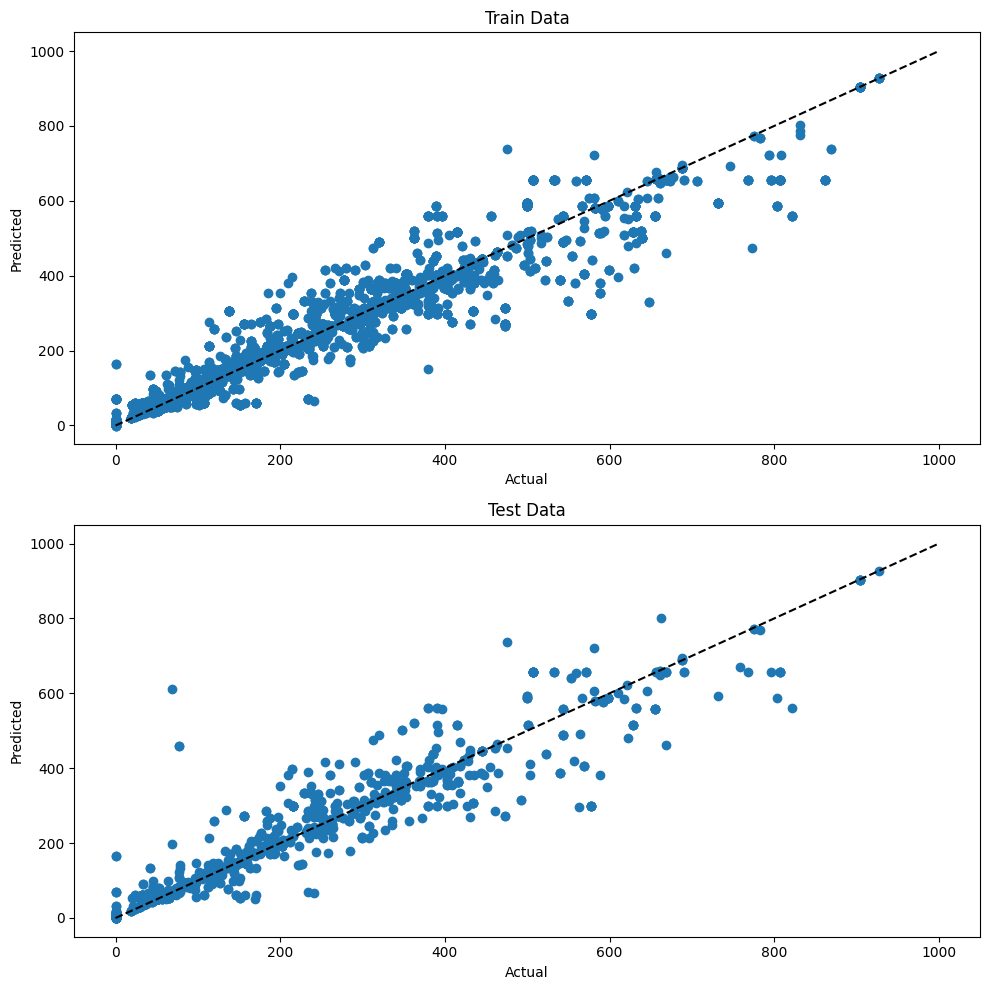

In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.scatter(Ytrain, Ptrain)
plt.plot([0, 1000], [0, 1000], "--k")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Train Data")

plt.subplot(2, 1, 2)
plt.scatter(Ytest, Ptest)
plt.plot([0, 1000], [0, 1000], "--k")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test Data")

plt.tight_layout()
plt.show()

### Inference

In [23]:
import pickle
import numpy as np
import pandas as pd

In [24]:
with open("artifacts/encoder_co2_emmision.pkl", "rb") as f:
        encoder_co2 = pickle.load(f)
        
with open("artifacts/model_co2_emmision.pkl", "rb") as f:
        model_co2 = pickle.load(f)

In [ ]:
sample_json = {
            "Transmission":"M5",
            "Vehicle_Type":"Manual",
            "Engine_Capacity":1368,
            "Fuel_Type":"Petrol",
            "Powertrain":"Internal Combustion Engine (ICE)",
            "Engine_PowerPS":165
            }

In [28]:
def inference_co2(
                sample_json,
                cat_cols = [
                           'Transmission', 
                           'Vehicle_Type', 
                           'Fuel_Type',
                           'Powertrain'
                           ]):
        df = pd.DataFrame([sample_json])
        df = df.astype(str)
        for col in df.columns:
                if col in cat_cols:
                        df[col] = df[col].str.strip()
                        df[col] = encoder_co2[col].transform(df[col])
        X = df.values
        Ypred = model_co2.predict(X)
        return int(Ypred[0])

In [ ]:
inference_co2(sample_json)

688